## Пункт 2. Использование вариантов SGD (torch.optim) из PyTorch

In [258]:
import torch
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams["figure.figsize"] = (10, 5)

### custom SGD

In [259]:
DEFAULT_LR = 0.01
njev = 0
nfev = 0

constant_lr = (lambda current_lr, epoch: DEFAULT_LR)

def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))

In [260]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, delta = 0.):
    return np.sum(coefficients * x) + delta

class point_set:
    def __init__(self, n, dim, x, y, coefficients, delta, coords_bound = 0.):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coefficients = coefficients
        self.delta = delta
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    delta = np.asarray([0] * n)
    for i in range(0, n):
        delta[i] = coefficients_bound * (2 * np.random.random_sample() - 1)
        y = np.append(y, f(coefficients, x[i], delta[i]))
    return point_set(n, dim, x, y, coefficients, delta, coords_bound)


EPOCH_MAX = 500
input_2d = create_point_set(200, 2, 20., 10.)
input_large = create_point_set(200, 10, 20., 10.)

In [261]:
def loss_function(points, coeffs, i):
    return 1 / (points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

In [262]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0.
    return grad

def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [263]:
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, _param_1, _param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [264]:
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [265]:
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result

def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        coeffs = coeffs_step
        loss_history.append(apply_all_loss_functions(points, coeffs))

        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [266]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [267]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v * betta + (1 - betta) * np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [268]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.01] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]


### torch.optim SGD

In [269]:
def Linear_to_array(model):
    return np.append(model.weight.detach().numpy()[0], model.bias.detach().numpy()[0])

In [270]:
def linear_regression(coeffs, points):
    y = np.asarray([0.] * points.n)
    for i in range(0, points.n):
        y[i] = coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1].detach().numpy() * points.x[i])
    return torch.tensor(y, requires_grad=True)

# points - point_set instance
def torch_sgd(points, model, optimizer, scheduler, eps):
    xs = torch.tensor(points.x, requires_grad=True).float()
    ys = torch.tensor(np.asarray([points.y]).T).float()

    loss_history = list()
    total_epoches = 0
    
    previous_coeffs = np.zeros(points.dim)

    for epoch in range(0, EPOCH_MAX):
        coeffs = model(xs)
        loss = torch.nn.functional.mse_loss(coeffs, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        current_coeffs = Linear_to_array(model)
        if LA.norm(current_coeffs - previous_coeffs) <= eps:
            break
        
        previous_coeffs = current_coeffs

        total_epoches += 1
        loss_history.append(float(loss) / points.n)
        
    return [Linear_to_array(model), total_epoches, loss_history]
        

### tests 

In [271]:
def draw_2d_result(points, result):
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

def print_result(points, result, tittle=''):
    print(tittle, "sgd result:")
    print("coeffs:", result[0])
    print("epoches:", result[1])
    print("loss:", result[2][-1])
    
    if points.dim == 2:
        draw_2d_result(points, result)

    print('\n')

def draw_loss(custom_result, result):
    plt.plot(custom_result, label='custom loss')
    plt.plot(result, label='torch loss')
    plt.grid()
    plt.legend()
    plt.show()


In [272]:
def compare_sgd(points, optimizer_getter, custom_gd, current_lr, eps = 1e-6, param_1 = 0, param_2 = 0):

    model = torch.nn.Linear(points.dim - 1, 1)
    starting_coeffs = Linear_to_array(model)

    optimizer = optimizer_getter(model)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)
    
    custom_result = custom_gd(points, points.n * 2 // 5, loss_function_grad, starting_coeffs, step_decay, current_lr, eps, EPOCH_MAX, param_1, param_2)    
    result = torch_sgd(points, model, optimizer, scheduler, eps)

    print_result(points, custom_result, 'custom')
    print_result(points, result, 'torch')
    draw_loss(custom_result[2], result[2])

#### SGD

custom sgd result:
coeffs: [-7.20012126 -0.35588455]
epoches: 33
loss: 0.02545699040165065


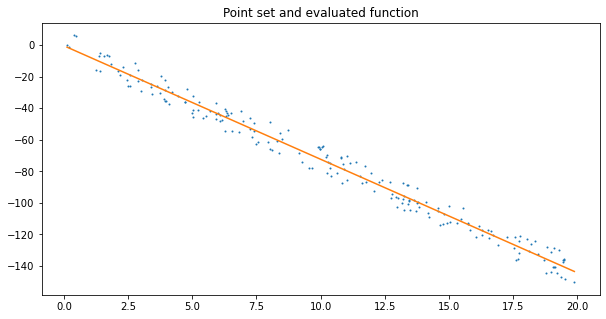



torch sgd result:
coeffs: [-7.143654   -0.35552207]
epoches: 36
loss: 0.14557476043701173


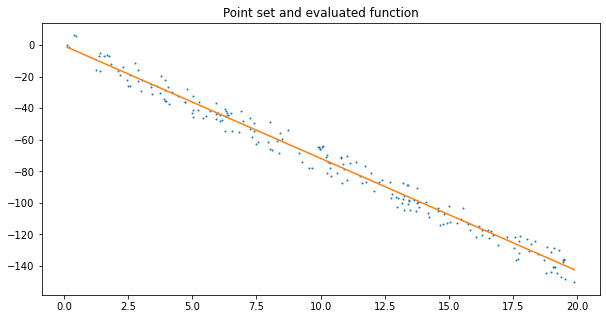

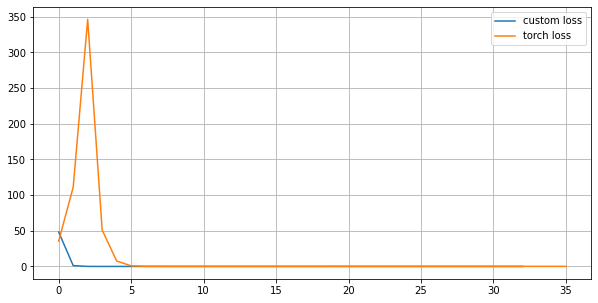

===large input===

custom sgd result:
coeffs: [-4.91573262 -3.60500843 -4.01102135 -3.70210159 -4.34814459 -3.4839503
 -3.04937917 -3.45332676 -5.22977303 -0.23389596]
epoches: 35
loss: 60.045738654365024


torch sgd result:
coeffs: [-4.6643596  -3.6628072  -3.8259866  -3.753127   -4.356661   -3.6203923
 -3.349541   -3.688537   -4.9425926  -0.23184365]
epoches: 36
loss: 3.9306683349609375




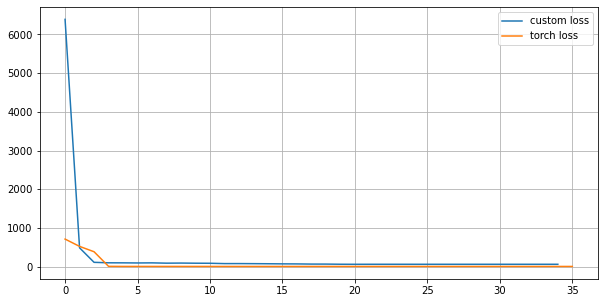

In [273]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR), sgd, DEFAULT_LR)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001), sgd, 0.001)

#### SGD with momentum

custom sgd result:
coeffs: [-7.18223097 -0.3797521 ]
epoches: 34
loss: 0.02881634107814051


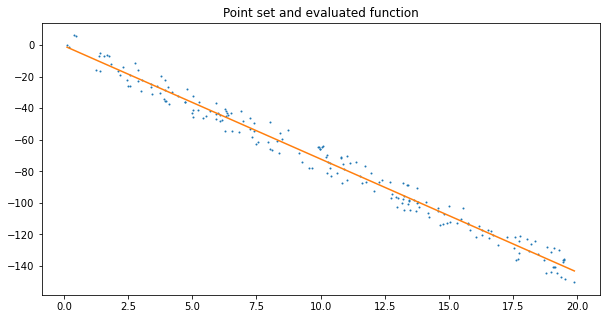



torch sgd result:
coeffs: [-6.689745   -0.32905492]
epoches: 44
loss: 0.32885009765625


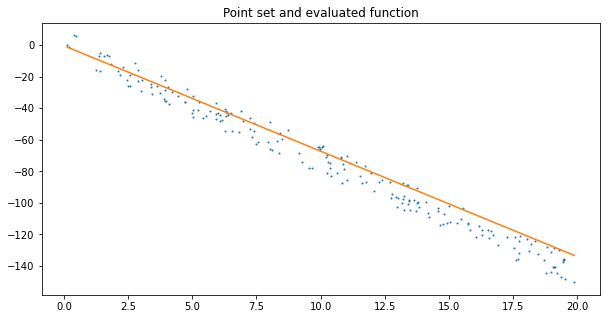

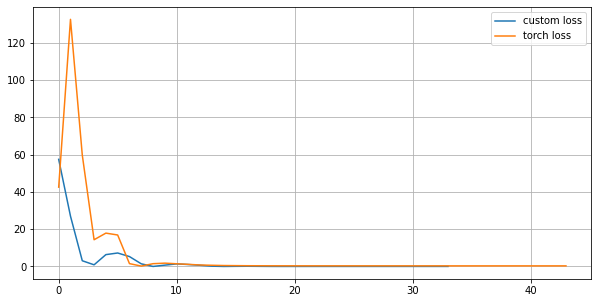

===large input===

custom sgd result:
coeffs: [-7.47199335 -3.34958909 -5.28602978 -4.16579404 -4.31308766 -1.47768573
  0.36769495 -1.36076644 -7.28858712 -0.23199302]
epoches: 39
loss: 12.963127824234066


torch sgd result:
coeffs: [-27534.78   -25642.334  -23711.207  -25669.229  -25777.545  -25961.43
 -26127.473  -26610.502  -25963.941   -2499.4407]
epoches: 64
loss: 28051513016.32




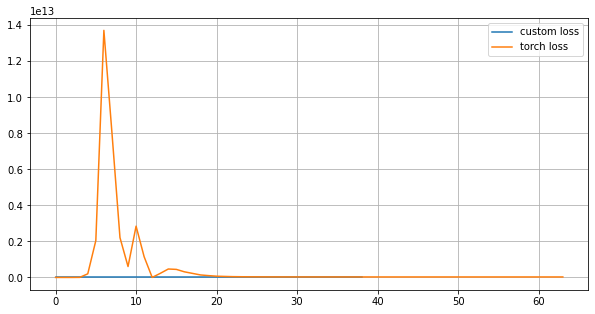

In [274]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7), sgd_with_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.8), sgd_with_momentum, DEFAULT_LR, param_1=0.8)

#### SGD with Nesterov momentum

custom sgd result:
coeffs: [-7.20670522 -0.49710486]
epoches: 48
loss: 0.023849565741046828


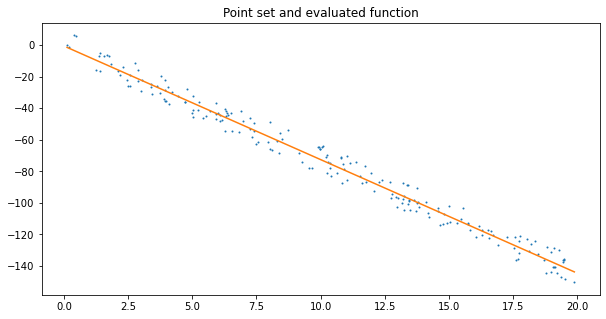



torch sgd result:
coeffs: [-7.206187   -0.40972394]
epoches: 31
loss: 0.14273571014404296


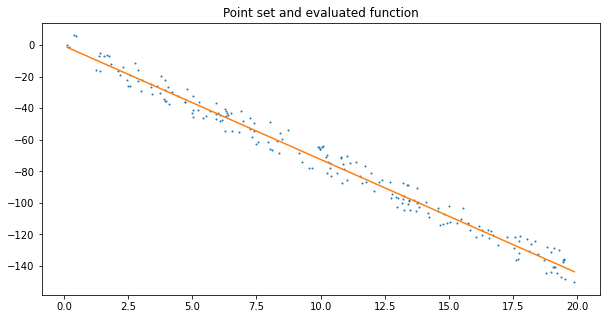

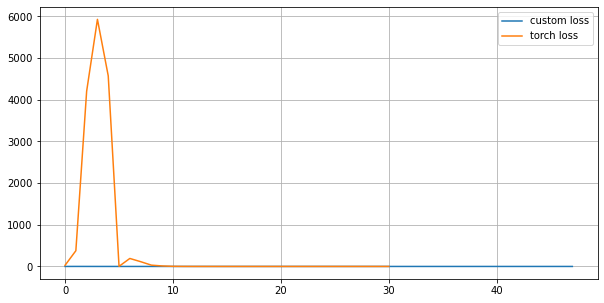

===large input===

custom sgd result:
coeffs: [-8.54624854 -3.80918427 -5.54852256 -5.02944271 -3.84881807 -1.50940603
  0.97989414 -0.90837383 -7.84215056 -0.72038741]
epoches: 138
loss: 14.79636708754321


torch sgd result:
coeffs: [-5.7121944 -3.4852247 -4.4659967 -3.478074  -4.31466   -2.5921588
 -1.7434927 -2.8321943 -6.098311  -0.6678059]
epoches: 48
loss: 1.770677490234375




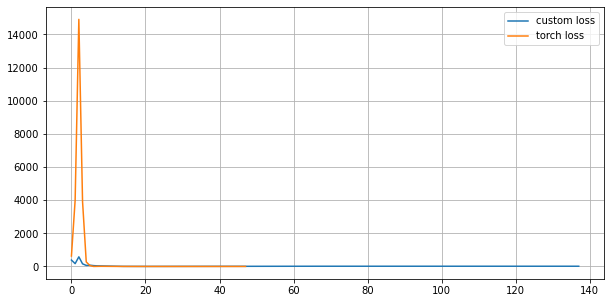

In [275]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7, nesterov=True), sgd_with_nesterov_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True), sgd_with_nesterov_momentum, 0.001, param_1=0.9)


#### Adagrad

custom sgd result:
coeffs: [-6.55406304 -6.00377485]
epoches: 34
loss: 0.18847623736728564


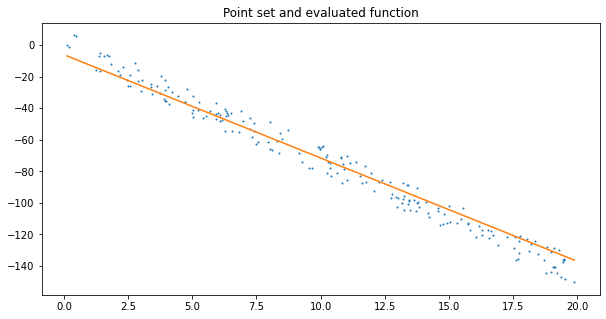



torch sgd result:
coeffs: [-3.914606 -3.523386]
epoches: 38
loss: 6.57613525390625


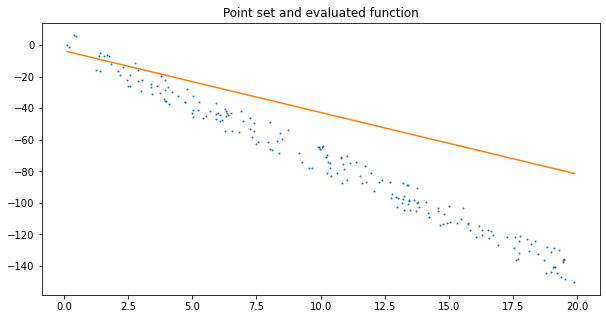

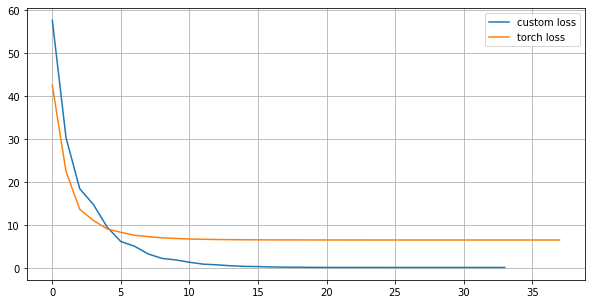

===large input===

custom sgd result:
coeffs: [-4.21151481 -4.17359888 -3.90919419 -3.64109351 -3.9337615  -3.82684462
 -3.5785724  -3.72236278 -4.35318614 -4.04566558]
epoches: 34
loss: 96.56915986280177


torch sgd result:
coeffs: [-3.1530628 -3.3211067 -2.923821  -2.8253512 -2.7897153 -2.9564571
 -2.9420776 -3.060987  -3.0481024 -3.0611525]
epoches: 38
loss: 44.287236328125




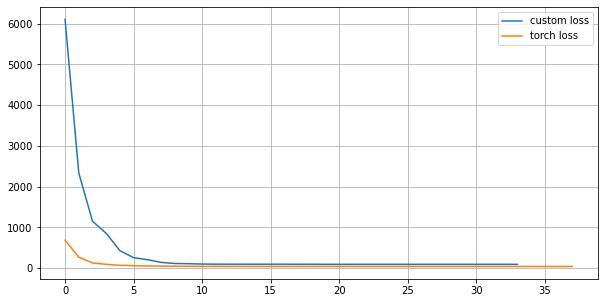

In [276]:
compare_sgd(input_2d, lambda model: torch.optim.Adagrad(model.parameters(), lr=2), adagrad, 2)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adagrad(model.parameters(), lr=1.5), adagrad, 1.5)

#### RMS Prop

custom sgd result:
coeffs: [-6.91740784 -4.13658889]
epoches: 36
loss: 0.08930163817035806


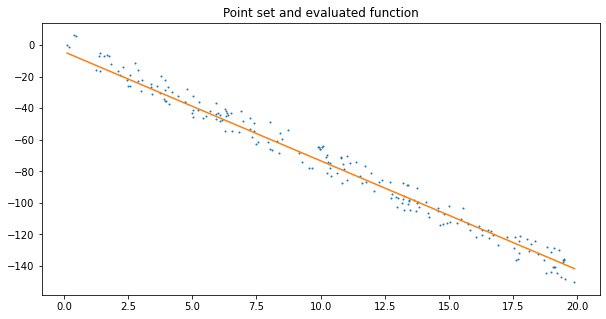



torch sgd result:
coeffs: [-6.7653217 -5.723688 ]
epoches: 36
loss: 0.17553319931030273


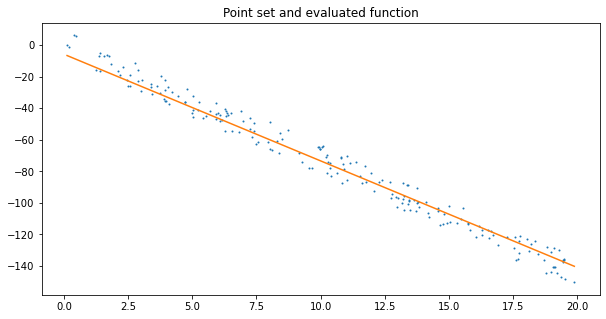

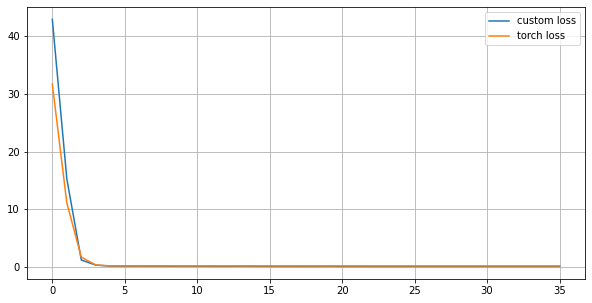

===large input===

custom sgd result:
coeffs: [-5.84784291 -3.53352372 -5.03231625 -3.8627803  -4.09236596 -2.59096037
 -1.75546514 -2.63264919 -6.31931671 -3.52279592]
epoches: 38
loss: 15.86718128874503


torch sgd result:
coeffs: [-3.0220127 -2.5179121 -2.8478513 -2.3257794 -2.4002752 -2.4141686
 -2.154994  -2.2588904 -3.329865  -2.280614 ]
epoches: 50
loss: 84.35130859375




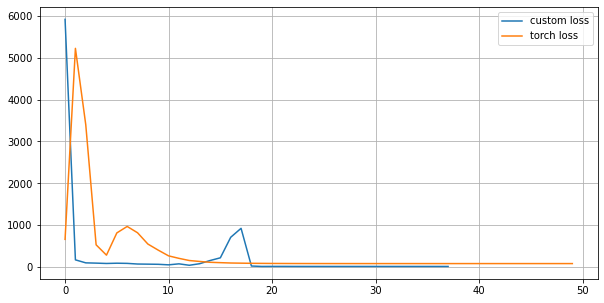

In [277]:
compare_sgd(input_2d, lambda model: torch.optim.RMSprop(model.parameters(), lr=1), rms_prop, 1, param_1=0.99)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.RMSprop(model.parameters(), lr=1.5, momentum=0.8), rms_prop, 1.5, param_1=0.8)

#### Adam

custom sgd result:
coeffs: [-6.5410547  -3.99797557]
epoches: 38
loss: 0.2437991223380725


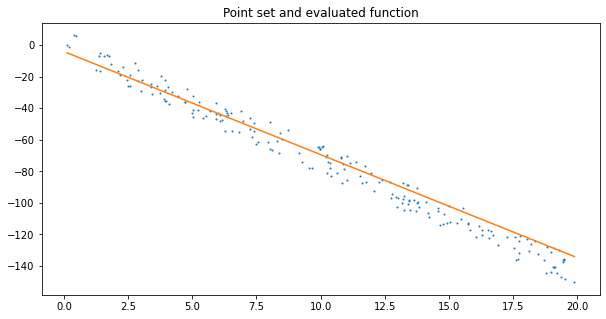



torch sgd result:
coeffs: [-4.5383286 -4.5596633]
epoches: 42
loss: 3.9741131591796877


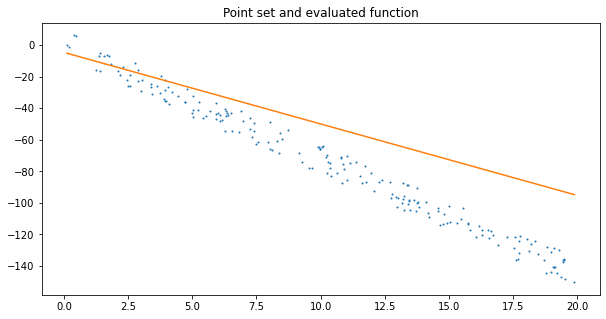

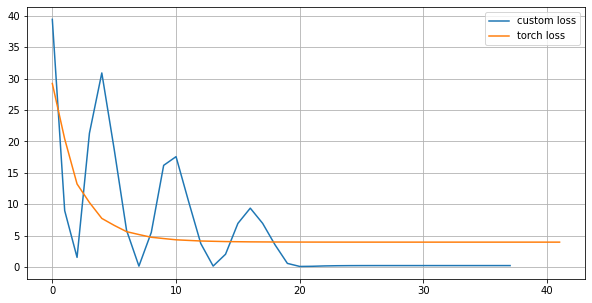

===large input===

custom sgd result:
coeffs: [-4.47617489 -3.34992748 -4.09637127 -3.24792456 -3.73517874 -2.98560977
 -2.72387595 -3.44710507 -4.65009152 -3.50319517]
epoches: 39
loss: 79.15163309257122


torch sgd result:
coeffs: [-4.0438023 -3.5541089 -4.0779743 -3.4577959 -3.6082985 -3.5765705
 -3.6431007 -4.0294914 -3.8609068 -3.6174514]
epoches: 44
loss: 7.264913330078125




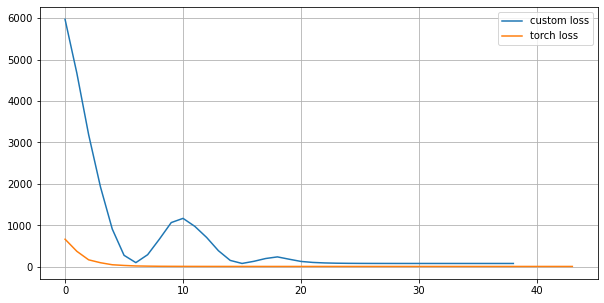

In [278]:
compare_sgd(input_2d, lambda model: torch.optim.Adam(model.parameters(), lr=1), adam, 1, param_1=0.9, param_2=0.999)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adam(model.parameters(), lr=1, betas=(0.8, 0.8)), adam, 1, param_1=0.8, param_2=0.8)